In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

In [2]:
def plot_training_hist(training_hist):
    '''
    training_hist: Dataframe constructed from hist.hist from training results.
    '''
    f, a = plt.subplots(1)
    a.plot(training_hist['loss'], label='loss')
    a.plot(training_hist['val_loss'], label='validation loss')
    a.set_xlabel('Epoch')
    a.set_ylabel('Error [Sales Price]')
    a.grid(1)
    a.legend()

In [27]:
def calcate_fig_shape(cols):
    total_figs = len(cols)
    vlen = int(total_figs**0.5)
    hlen = int(np.ceil(total_figs / vlen))
    print(f"Shape of fig: {(vlen, hlen)}")
    return vlen, hlen

def plot_scatter_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        ax.scatter(pdf[col], pdf['SalePrice'])
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

def plot_box_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        all_cats = df[col].unique()
        ax.boxplot([pdf.loc[pdf[col]==c, 'SalePrice'] for c in all_cats], labels=all_cats)
        if len(all_cats) > 5:
            ax.tick_params(axis='x', labelrotation= 45)
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

In [4]:
def label_columns(df, cols, label):
    for col in cols:
        df[col] = df[col].map(label).fillna(0).astype(int)

## Need to Clean data.
1. deal with null values. Are they actually missing or is it labeled as NA?
2. Label the categorical values with order -- 주로 qualitative grade.
2. Find worthy features to use in regression.
3. Find colinearities and minimize them.


In [5]:
train_df = pd.read_csv('rsc/train.csv')
test_df = pd.read_csv('rsc/test.csv')

couple rules to Think about. In real life situation, I have one dataset and I split the train and test sets. Here, I don't split them.\
Plus, I need to make results for all the test sets. I cannot drop them because of nan values. \
However, other processings are fair game.\
So, Drop what you don't like in the training set. That's fine. But don't drop from test sets.\
If you need to transform the data any way, you can do so on both train and test sets.

In [6]:
# Columns with NaN. -- I can only work with training data.
train_df.columns[train_df.isna().sum()>0]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [7]:
# Columns that should not include NaN -- dropthem but only on trainsets.
missing_val = ['Electrical']
print(train_df.shape, '->', train_df.dropna(subset=missing_val).shape)
train_df.dropna(subset=missing_val, inplace=True)
df= pd.concat([train_df, test_df]).reset_index(drop=True)

(1460, 81) -> (1459, 81)


In [8]:
# Columns with NA category
na_cat = ['Alley', 'MasVnrType','GarageType', 'MiscFeature']
for c in na_cat:
    df[c] = df[c].fillna('NA')

In [9]:
# Columns that NaN should be zero -- numeric
zero_cat = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for c in na_cat:
    df[c] = df[c].fillna(0)

In [10]:
# columns : labels -- int, qualitative
grading_scheme =[
    (['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'], {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2,'Po':1, np.nan:0}),
    (['BsmtExposure'], {'Gd':4, 'Av':3, 'Mn':2,'No':1, np.nan:0}),
    (['BsmtFinType1', 'BsmtFinType2'], {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2,'Unf':1, np.nan:0}),
    (['Functional'], {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4,'Maj1':3,'Maj2':2, 'Sev':1, 'Sal':0}),
    (['GarageFinish'], {'Fin':3, 'RFn':2,'Unf':1, np.nan:0}),
    (['PavedDrive', 'CentralAir'], {'Y':2,'P':1,'N':0}),
    (['Fence'], {'GdPrv':4, 'MnPrv':3, 'GdWo':2,'MnWw':1, np.nan:0})
]
for cols_to_label, label in grading_scheme:
    label_columns(df, cols_to_label, label)

## NaN and Labeling done
Now find features that seems to be affecting the saleprice.

In [11]:
train_df = df[:len(train_df)]
test_df = df[len(train_df):].drop(columns=['SalePrice'])

In [16]:
categorical_cols = df.dtypes[df.dtypes == object].index
numeric_cols = df.dtypes[df.dtypes != object].index

Shape of fig: (5, 5)


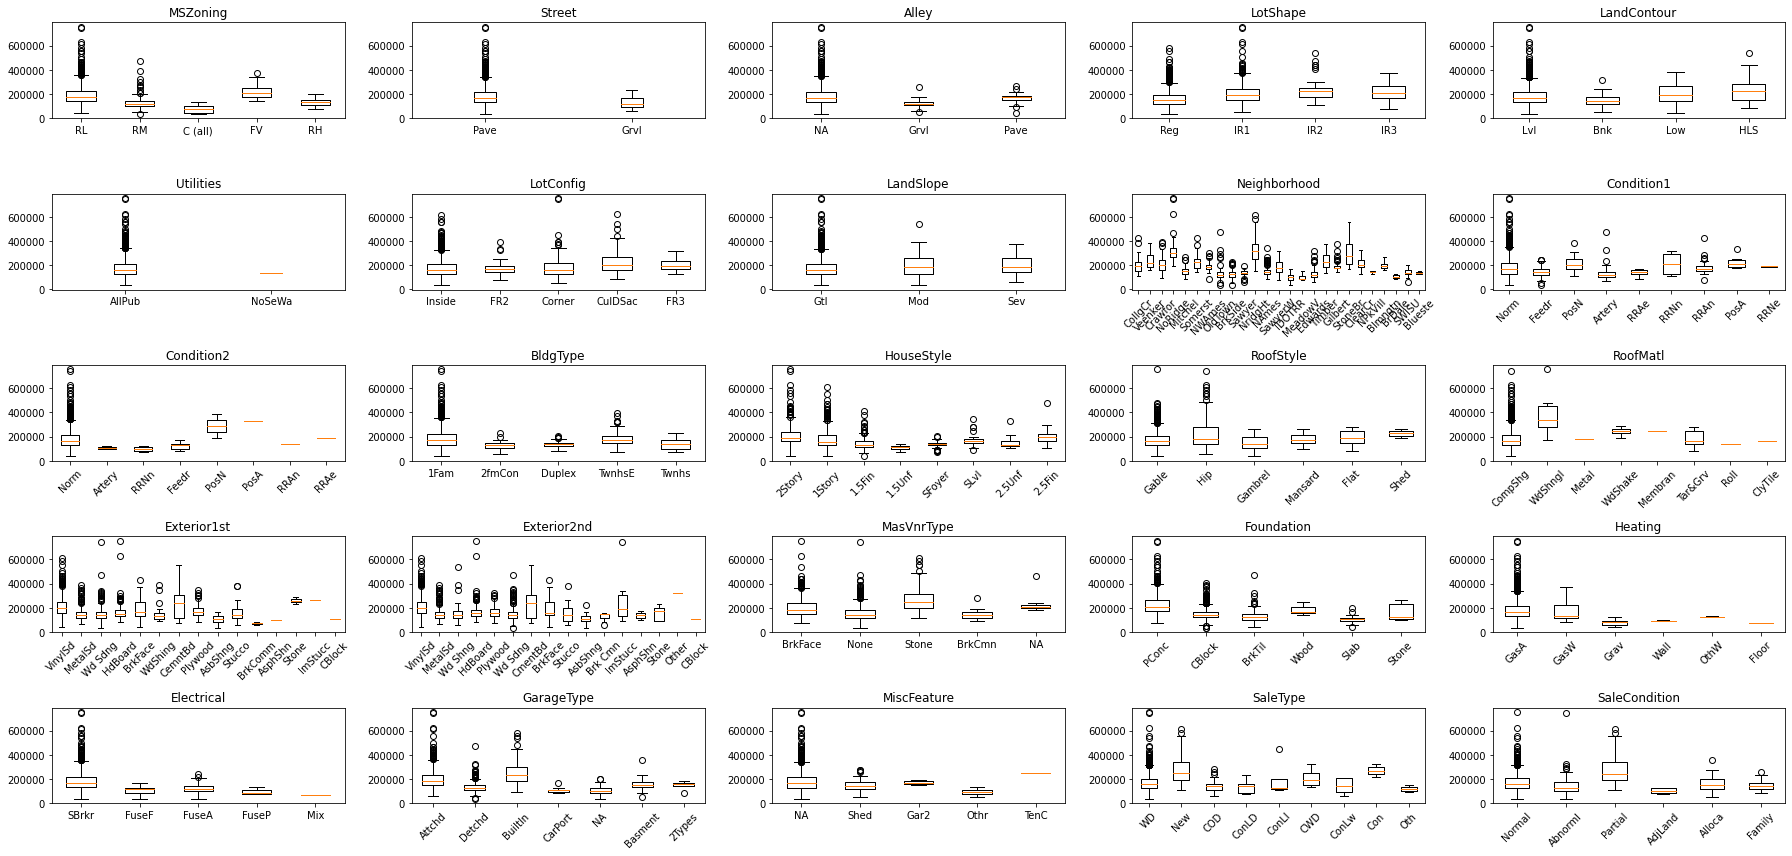

In [28]:
plot_box_matrix(train_df, categorical_cols)

Shape of fig: (7, 8)


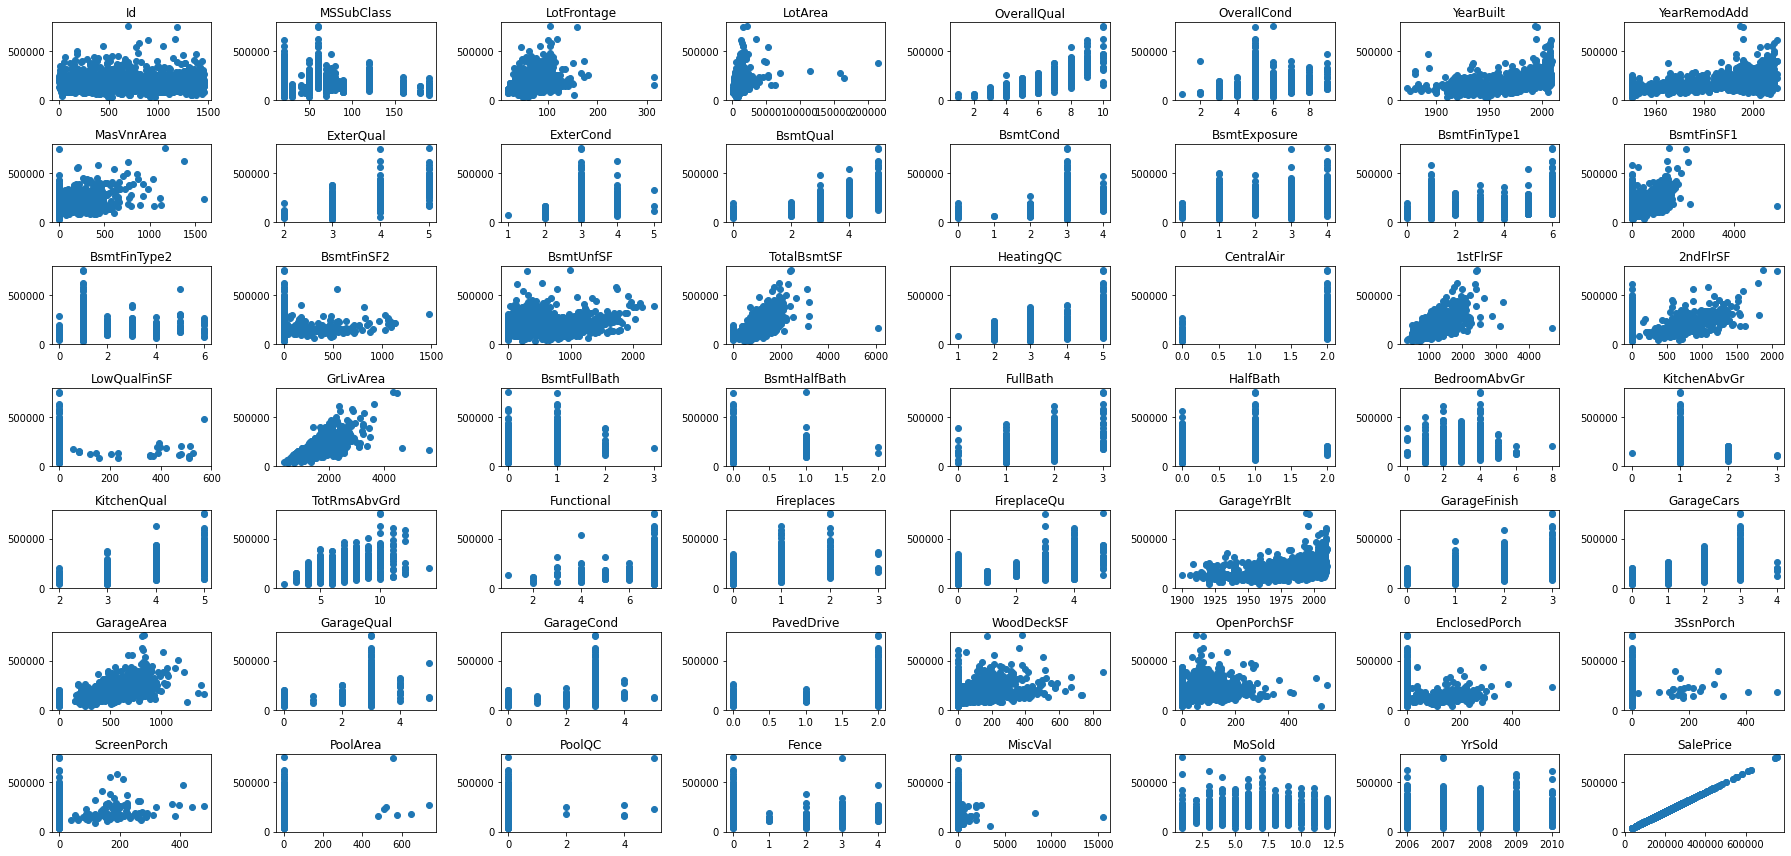

In [18]:
plot_scatter_matrix(train_df, numeric_cols)

In [31]:
corr = df[numeric_cols].corr()

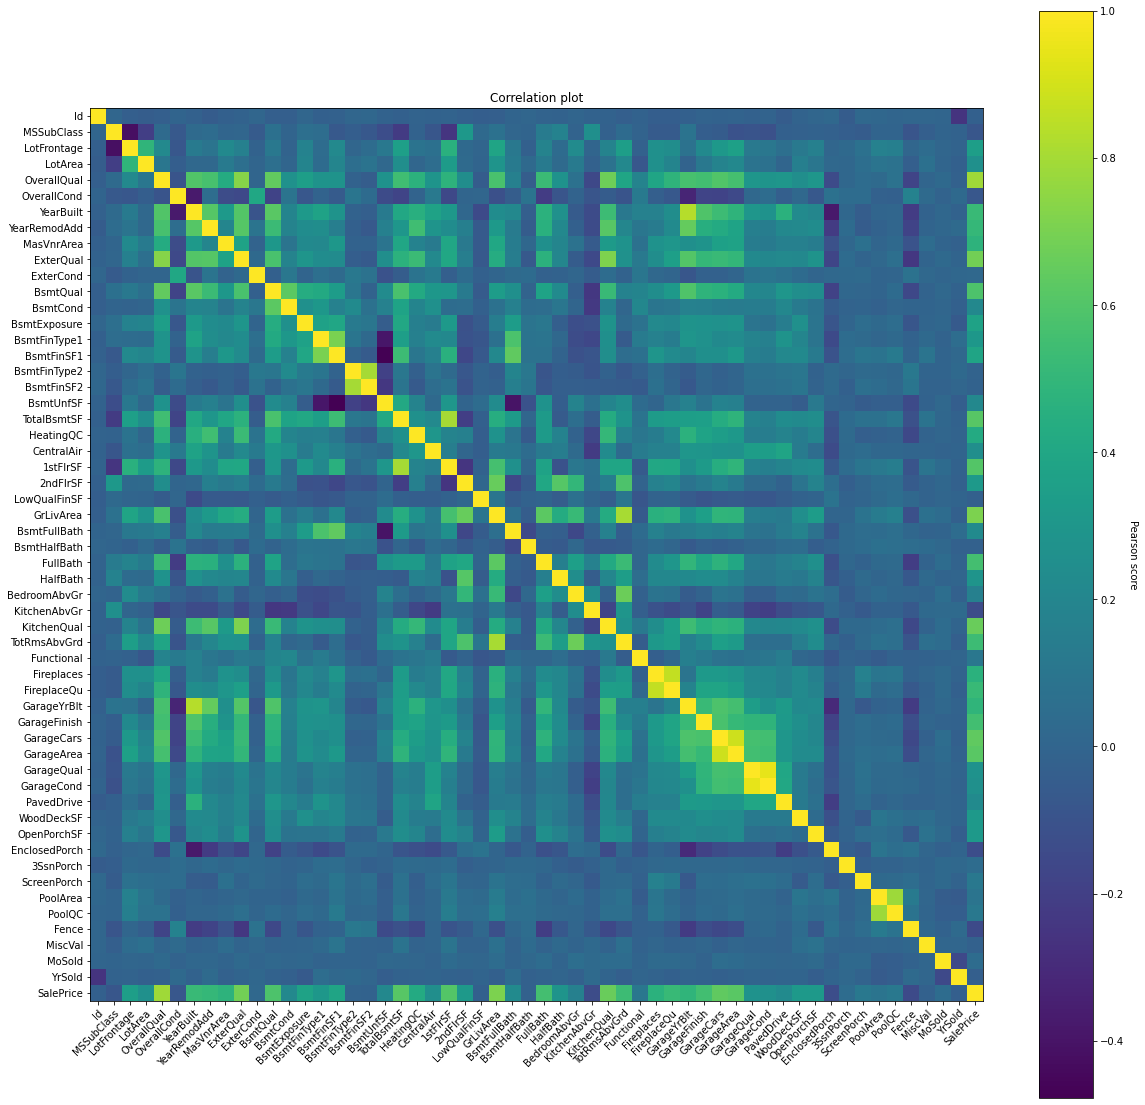

In [32]:
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(corr)
ax.set_xticks(np.arange(len(cols_to_plot)))
ax.set_yticks(np.arange(len(cols_to_plot)))
ax.set_xticklabels(cols_to_plot)
ax.set_yticklabels(cols_to_plot)
ax.set_title('Correlation plot')
_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
_ = cbar.ax.set_ylabel("Pearson score", rotation=-90, va="bottom")

In [13]:
high_corr = []
indices = []
for index, row in corr.iterrows():
    no_dup = row[index:][1:]
    high_corr.append(no_dup.loc[no_dup.abs() > 0.5])
    indices.append(row.name)

In [14]:
high_corr_df = pd.concat(high_corr, keys =indices).to_frame('pearson score')

In [15]:
high_corr_df

pearson score
OverallQual  YearBuilt          0.572323
             YearRemodAdd       0.550684
             TotalBsmtSF        0.537808
             GrLivArea          0.593007
             FullBath           0.550600
             GarageYrBlt        0.547766
             GarageCars         0.600671
             GarageArea         0.562022
YearBuilt    YearRemodAdd       0.592855
             GarageYrBlt        0.825667
             GarageCars         0.537850
YearRemodAdd GarageYrBlt        0.642277
BsmtFinSF1   TotalBsmtSF        0.522396
             BsmtFullBath       0.649212
TotalBsmtSF  1stFlrSF           0.819530
1stFlrSF     GrLivArea          0.566024
2ndFlrSF     GrLivArea          0.687501
             HalfBath           0.609707
             BedroomAbvGr       0.502901
             TotRmsAbvGrd       0.616423
GrLivArea    FullBath           0.630012
             BedroomAbvGr       0.521270
             TotRmsAbvGrd       0.825489
FullBath     TotRmsAbvGrd       0.554784
BedroomAbvGr TotRmsAbvGrd       0.676620
GarageYrBlt  GarageCars         0.588920
             GarageArea         0.564567
GarageCars   GarageArea         0.882475

In [23]:
to_one_hot_cols=[
    'MSZoning','Alley', 'LotShape','LandContour','LotConfig',
    'LandSlope','Neighborhood','Condition1','BldgType',
    'HouseStyle','RoofStyle','Exterior1st','MasVnrType',
    'Foundation','Electrical','GarageType','MiscFeature','SaleCondition']

df_onehot = pd.get_dummies(df, columns=to_one_hot_cols, drop_first=True, prefix='', prefix_sep='')[df.dtypes[df.dtypes != object].index]

In [40]:
train_dataset = df_onehot[:len(train_df)].drop(columns=['Id', 'SalePrice'])
test_dataset = df_onehot[len(train_df):].drop(columns=['Id', 'SalePrice'])
target = df_onehot[:len(train_df)]['SalePrice']

In [16]:
# TODO:
# separate integer columns and see if they are indeed numeric or categorical
# include string columns. See what relation do they have. e.g. are the representing size? like small medium large? Then switch to categorical.

# Regression Part

### Linear regression


In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense
physical_devices = tf.config.list_physical_devices('GPU')
print(f'Tensorflow found {len(physical_devices)} GPU.')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Tensorflow found 1 GPU.


In [18]:
ovq = df[['OverallQual']]
target = df[['SalePrice']]

In [19]:
ovq.shape

(1460, 1)

In [20]:
normalizer = Normalization(input_shape=(ovq.shape[1],))

In [21]:
normalizer.adapt(ovq.to_numpy())

In [22]:
svmodel = tf.keras.models.Sequential([
    normalizer,
    Dense(units=1)
])
svmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [23]:
svmodel.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.1),
    loss='MAE')


In [24]:
%%time
history = svmodel.fit(
                ovq,
                target,
                epochs=100,
                verbose=0,
                validation_split=0.2)

Wall time: 14.1 s


In [25]:
def plot_training_hist(training_hist):
    '''
    training_hist: Dataframe constructed from hist.hist from training results.
    '''
    f, a = plt.subplots(1)
    a.plot(training_hist['loss'], label='loss')
    a.plot(training_hist['val_loss'], label='validation loss')
    a.set_xlabel('Epoch')
    a.set_ylabel('Error [Sales Price]')
    a.grid(1)
    a.legend()

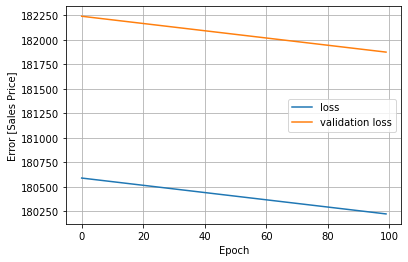

In [26]:
training_hist = pd.DataFrame.from_dict(history.history, orient='columns')
training_hist.index.name = 'epoch'
plot_training_hist(training_hist)

이걸 DNN 모델로 해보자.

In [27]:
sv_dnn_model = tf.keras.models.Sequential([
    normalizer,
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])
sv_dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [28]:
sv_dnn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate = 0.01), # 10배 작아졌네 -- 크면 너무 불안정해서 잘 못배움 10으로 한자리씩 낮춰가면서 찾아.
    loss='MAE')

In [29]:
%%time
history = sv_dnn_model.fit(
    ovq,
    target,
    epochs=100,
    verbose=0,
    validation_split=0.2)

Wall time: 14.9 s


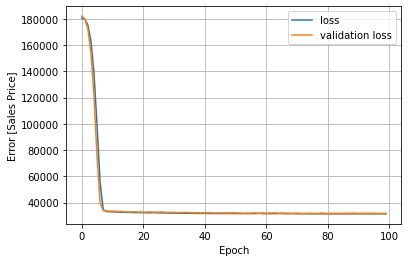

In [30]:
training_hist = pd.DataFrame.from_dict(history.history, orient='columns')
training_hist.index.name = 'epoch'
plot_training_hist(training_hist)

헐 이거 왜 이렇게 세?

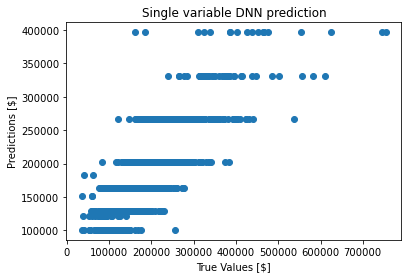

In [31]:
x = ovq
y = target
y_hat = sv_dnn_model.predict(ovq).flatten()
f,a = plt.subplots(1)
a.set_title('Single variable DNN prediction')
a.set_xlabel('True Values [$]')
a.set_ylabel('Predictions [$]')
a.scatter(y, y_hat)

아무래도 overall Quality가 integer category값이라 이렇게 나오는군.

### Multi variate regression
그냥 다 넣어버리면 어떨까?

1. 모든 string one-hot vector로 만들기. -- use pd.get_dummies(df, columns=[str cols], prefix='', prefix_sep='')
2. scatter matrix 다시 만들기
3. 모든 col 사용해서 dnn 구축

Some Manual work before one-hot encoding.
Need to identify what columns to work with.

In [36]:
to_one_hot_cols=[
    'MSZoning','Alley', 'LotShape','LandContour','LotConfig',
    'LandSlope','Neighborhood','Condition1','BldgType',
    'HouseStyle','RoofStyle','Exterior1st','MasVnrType',
    'Foundation','Electrical','GarageType','MiscFeature','SaleCondition']

In [110]:
df_onehot = pd.get_dummies(df, columns=to_one_hot_cols, drop_first=True, prefix='', prefix_sep='')[df.dtypes[df.dtypes != object].index]

In [112]:
dnn_norm = Normalization(input_shape=(train_dataset.shape[1],))
dnn_norm.adapt(train_dataset.to_numpy())

In [125]:
dnn_norm(train_dataset[:1])

<tf.Tensor: shape=(1, 54), dtype=float32, numpy=
array([[ 7.33749941e-02,  6.50000000e+08, -2.07141697e-01,
         6.51479185e-01, -5.17199993e-01,  1.05099332e+00,
         8.78669560e-01,  1.96000000e+09,  1.05230212e+00,
        -2.38112405e-01,  4.00000000e+07,  3.00000000e+07,
         1.00000000e+07,  6.00000000e+07,  5.75424790e-01,
         1.00000000e+07, -2.88652837e-01, -9.44590628e-01,
        -4.59302515e-01,  8.91179383e-01,  2.63812542e-01,
        -7.93433785e-01,  1.16185164e+00, -1.20241724e-01,
         3.70333344e-01,  1.10781014e+00, -2.41061032e-01,
         7.89740503e-01,  1.22758532e+00,  1.63779080e-01,
        -2.11453423e-01,  7.35994279e-01,  9.12209630e-01,
         2.37043783e-01, -9.51226532e-01,             nan,
         2.00299991e+10,  2.00000000e+07,  3.11724573e-01,
         3.51000339e-01,  3.00000000e+07,  3.00000000e+07,
         2.89744854e-01, -7.52175808e-01,  2.16503143e-01,
        -3.59324902e-01, -1.16339281e-01, -2.70208359e-01,
       

In [126]:
train_dataset[:1]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,4,3,4.0,3.0,1.0,6.0,706,1.0,0,150,856,5,2,856,854,0,1710,1,0,2,1,3,1,4,8,7,0,NaN,2003.0,2.0,2,548,3.0,3.0,2,0,61,0,0,0,0,NaN,NaN,0,2,2008


In [122]:
dnn_model = tf.keras.models.Sequential([
    dnn_norm,
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])
dnn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='MSE')

In [123]:
history = dnn_model.fit(train_dataset, target,
             validation_split=0.2,
             epochs=1000,
            verbose=False
             )

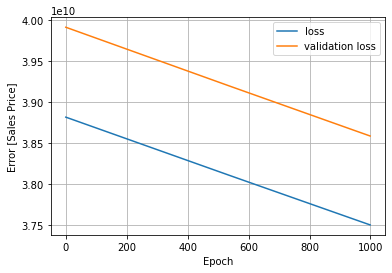

In [124]:
training_hist = pd.DataFrame.from_dict(history.history, orient='columns')
training_hist.index.name = 'epoch'
plot_training_hist(training_hist)